In [1]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
import tensorflow as tf
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import tensorflow_probability as tfp
from tensorflow.keras import layers

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data


## Data Preprocessing

In [3]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/np.sqrt(Y_scalar)
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [4]:
X=X_s.copy()
Y_obs=Y_np.copy()
Y_shifted=Y.values.mean()
Y_std=Y.values.std()
Y=(Y.values-Y.values.mean())/(Y.values.std())
# Y=np.array([Yi.flatten() for Yi in Y])

In [5]:
Y=Y.reshape(250,24,48)

## Cross Validation

In [6]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

## Model

In [260]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=5))
model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Reshape((3,3,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=7,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=7,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=7,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=5,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=5,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=5,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=5,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))

In [261]:
lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=1000,decay_rate=0.8)

In [262]:
def custom_loss(y_actual,y_pred):
    err=y_actual-y_pred
    z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
    weights=z/kb.sum(z)
    custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
    #custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

244.69193226422033


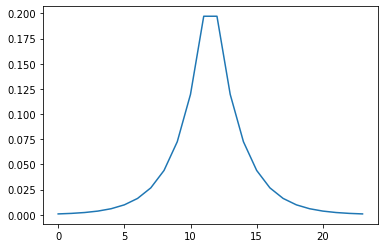

In [263]:
z=np.exp(-np.abs(np.arange(24,dtype=float)-11.5)/2+1e-3)
weights=z/np.sum(z)
print(z[11]/z[-1])
plt.plot(weights)

In [264]:
model.compile(optimizer=tf.optimizers.Adam(1e-4),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])

In [265]:
history=model.fit(X_train,Y_train,epochs=1000)

Epoch 1/1000
7/7 [==============================] - 3s 94ms/step - loss: 0.1694 - root_mean_squared_error: 1.0960
Epoch 2/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.1658 - root_mean_squared_error: 1.0888
Epoch 3/1000
7/7 [==============================] - 0s 35ms/step - loss: 0.1628 - root_mean_squared_error: 1.0843
Epoch 4/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1603 - root_mean_squared_error: 1.0797
Epoch 5/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1581 - root_mean_squared_error: 1.0759
Epoch 6/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.1558 - root_mean_squared_error: 1.0717
Epoch 7/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.1542 - root_mean_squared_error: 1.0683
Epoch 8/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1522 - root_mean_squared_error: 1.0646
Epoch 9/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1503 - root_m

7/7 [==============================] - 0s 17ms/step - loss: 0.0931 - root_mean_squared_error: 0.8426
Epoch 73/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0920 - root_mean_squared_error: 0.8396
Epoch 74/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0913 - root_mean_squared_error: 0.8367
Epoch 75/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0906 - root_mean_squared_error: 0.8332
Epoch 76/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0898 - root_mean_squared_error: 0.8309
Epoch 77/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0893 - root_mean_squared_error: 0.8273
Epoch 78/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0885 - root_mean_squared_error: 0.8252
Epoch 79/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0881 - root_mean_squared_error: 0.8228
Epoch 80/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0873 - root_mean_s

Epoch 143/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0630 - root_mean_squared_error: 0.6364
Epoch 144/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0630 - root_mean_squared_error: 0.6323
Epoch 145/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0622 - root_mean_squared_error: 0.6293
Epoch 146/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0627 - root_mean_squared_error: 0.6279
Epoch 147/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0620 - root_mean_squared_error: 0.6233
Epoch 148/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0616 - root_mean_squared_error: 0.6191
Epoch 149/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0615 - root_mean_squared_error: 0.6189
Epoch 150/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0611 - root_mean_squared_error: 0.6169
Epoch 151/1000
7/7 [==============================] - 0s 19ms/step - los

7/7 [==============================] - 0s 19ms/step - loss: 0.0499 - root_mean_squared_error: 0.4762
Epoch 214/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0508 - root_mean_squared_error: 0.4761
Epoch 215/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0501 - root_mean_squared_error: 0.4732
Epoch 216/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0500 - root_mean_squared_error: 0.4708
Epoch 217/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0496 - root_mean_squared_error: 0.4702
Epoch 218/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0496 - root_mean_squared_error: 0.4673
Epoch 219/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0499 - root_mean_squared_error: 0.4668
Epoch 220/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0501 - root_mean_squared_error: 0.4670
Epoch 221/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0492 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0439 - root_mean_squared_error: 0.3988
Epoch 284/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0436 - root_mean_squared_error: 0.3982
Epoch 285/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0437 - root_mean_squared_error: 0.3976
Epoch 286/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0438 - root_mean_squared_error: 0.3968
Epoch 287/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0438 - root_mean_squared_error: 0.3962
Epoch 288/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0436 - root_mean_squared_error: 0.3952
Epoch 289/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0436 - root_mean_squared_error: 0.3943
Epoch 290/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0433 - root_mean_squared_error: 0.3945
Epoch 291/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0438 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0397 - root_mean_squared_error: 0.3583
Epoch 354/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0397 - root_mean_squared_error: 0.3582
Epoch 355/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0393 - root_mean_squared_error: 0.3574
Epoch 356/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0395 - root_mean_squared_error: 0.3572
Epoch 357/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0401 - root_mean_squared_error: 0.3582
Epoch 358/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0400 - root_mean_squared_error: 0.3567
Epoch 359/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0394 - root_mean_squared_error: 0.3557
Epoch 360/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0390 - root_mean_squared_error: 0.3551
Epoch 361/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0399 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0379 - root_mean_squared_error: 0.3346
Epoch 424/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0396 - root_mean_squared_error: 0.3361
Epoch 425/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0376 - root_mean_squared_error: 0.3344
Epoch 426/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0383 - root_mean_squared_error: 0.3344
Epoch 427/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0375 - root_mean_squared_error: 0.3328
Epoch 428/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0370 - root_mean_squared_error: 0.3324
Epoch 429/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0374 - root_mean_squared_error: 0.3322
Epoch 430/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0378 - root_mean_squared_error: 0.3323
Epoch 431/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0368 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0350 - root_mean_squared_error: 0.3170
Epoch 494/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0365 - root_mean_squared_error: 0.3185
Epoch 495/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0351 - root_mean_squared_error: 0.3167
Epoch 496/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0350 - root_mean_squared_error: 0.3158
Epoch 497/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0353 - root_mean_squared_error: 0.3162
Epoch 498/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0352 - root_mean_squared_error: 0.3158
Epoch 499/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0355 - root_mean_squared_error: 0.3162
Epoch 500/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0350 - root_mean_squared_error: 0.3158
Epoch 501/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0348 - roo

7/7 [==============================] - 0s 18ms/step - loss: 0.0336 - root_mean_squared_error: 0.3033
Epoch 564/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0337 - root_mean_squared_error: 0.3038
Epoch 565/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0339 - root_mean_squared_error: 0.3035
Epoch 566/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0351 - root_mean_squared_error: 0.3044
Epoch 567/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0338 - root_mean_squared_error: 0.3038
Epoch 568/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0337 - root_mean_squared_error: 0.3031
Epoch 569/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0337 - root_mean_squared_error: 0.3032
Epoch 570/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0333 - root_mean_squared_error: 0.3027
Epoch 571/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0341 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0325 - root_mean_squared_error: 0.2940
Epoch 634/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0332 - root_mean_squared_error: 0.2943
Epoch 635/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0337 - root_mean_squared_error: 0.2944
Epoch 636/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0336 - root_mean_squared_error: 0.2950
Epoch 637/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0326 - root_mean_squared_error: 0.2940
Epoch 638/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0325 - root_mean_squared_error: 0.2934
Epoch 639/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0327 - root_mean_squared_error: 0.2934
Epoch 640/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0324 - root_mean_squared_error: 0.2934
Epoch 641/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0324 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0324 - root_mean_squared_error: 0.2866
Epoch 704/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0315 - root_mean_squared_error: 0.2859
Epoch 705/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0317 - root_mean_squared_error: 0.2858
Epoch 706/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0320 - root_mean_squared_error: 0.2865
Epoch 707/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0318 - root_mean_squared_error: 0.2858
Epoch 708/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0320 - root_mean_squared_error: 0.2858
Epoch 709/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0315 - root_mean_squared_error: 0.2856
Epoch 710/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0340 - root_mean_squared_error: 0.2877
Epoch 711/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0326 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0325 - root_mean_squared_error: 0.2812
Epoch 774/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0329 - root_mean_squared_error: 0.2816
Epoch 775/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0306 - root_mean_squared_error: 0.2795
Epoch 776/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0310 - root_mean_squared_error: 0.2797
Epoch 777/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0307 - root_mean_squared_error: 0.2795
Epoch 778/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0314 - root_mean_squared_error: 0.2799
Epoch 779/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0304 - root_mean_squared_error: 0.2790
Epoch 780/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0316 - root_mean_squared_error: 0.2805
Epoch 781/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0308 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0298 - root_mean_squared_error: 0.2738
Epoch 844/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0303 - root_mean_squared_error: 0.2745
Epoch 845/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0305 - root_mean_squared_error: 0.2746
Epoch 846/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0305 - root_mean_squared_error: 0.2742
Epoch 847/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0304 - root_mean_squared_error: 0.2741
Epoch 848/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0306 - root_mean_squared_error: 0.2740
Epoch 849/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0300 - root_mean_squared_error: 0.2732
Epoch 850/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0315 - root_mean_squared_error: 0.2755
Epoch 851/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0310 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0309 - root_mean_squared_error: 0.2704
Epoch 914/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0297 - root_mean_squared_error: 0.2689
Epoch 915/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0293 - root_mean_squared_error: 0.2685
Epoch 916/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0295 - root_mean_squared_error: 0.2689
Epoch 917/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0300 - root_mean_squared_error: 0.2691
Epoch 918/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0290 - root_mean_squared_error: 0.2679
Epoch 919/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0295 - root_mean_squared_error: 0.2684
Epoch 920/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0297 - root_mean_squared_error: 0.2685
Epoch 921/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0298 - roo

7/7 [==============================] - 0s 19ms/step - loss: 0.0295 - root_mean_squared_error: 0.2647
Epoch 984/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0298 - root_mean_squared_error: 0.2649
Epoch 985/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0290 - root_mean_squared_error: 0.2640
Epoch 986/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0296 - root_mean_squared_error: 0.2643
Epoch 987/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0289 - root_mean_squared_error: 0.2636
Epoch 988/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0294 - root_mean_squared_error: 0.2638
Epoch 989/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0301 - root_mean_squared_error: 0.2645
Epoch 990/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0304 - root_mean_squared_error: 0.2650
Epoch 991/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0304 - roo

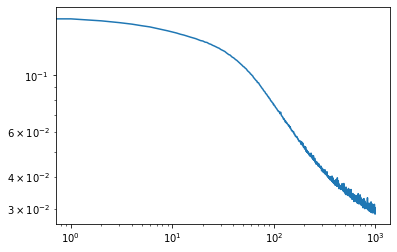

In [266]:
plt.loglog(history.history['loss'])
# plt.set_yscale('log')


In [267]:
model.evaluate(X_train,Y_train)

7/7 [==============================] - 1s 36ms/step - loss: 0.0275 - root_mean_squared_error: 0.2615


[0.02754000760614872, 0.2614537179470062]

In [268]:
model.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 182ms/step - loss: 0.0306 - root_mean_squared_error: 0.2653


[0.030635327100753784, 0.26527467370033264]

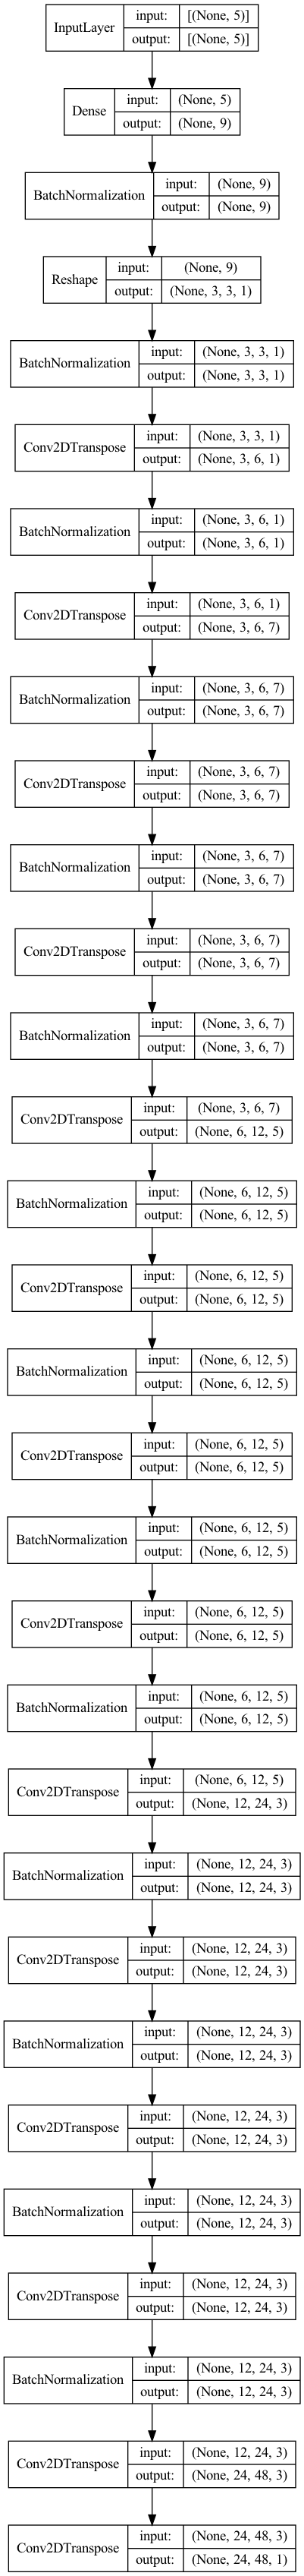

In [269]:
plot_model(model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [270]:
Y_pred=model.predict(X_test)

In [271]:
def plot(Y_pred,Y_test,i=0):
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    Y_plot=np.reshape(Y_pred[i],(24,48))
    y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_pred",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_pred_xr)
    Y_plot=np.reshape(Y_test[i],(24,48))
    y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_actual",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_obs_xr)
    sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
    )
    sample_plot.show((y_pred_xr-y_obs_xr))

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

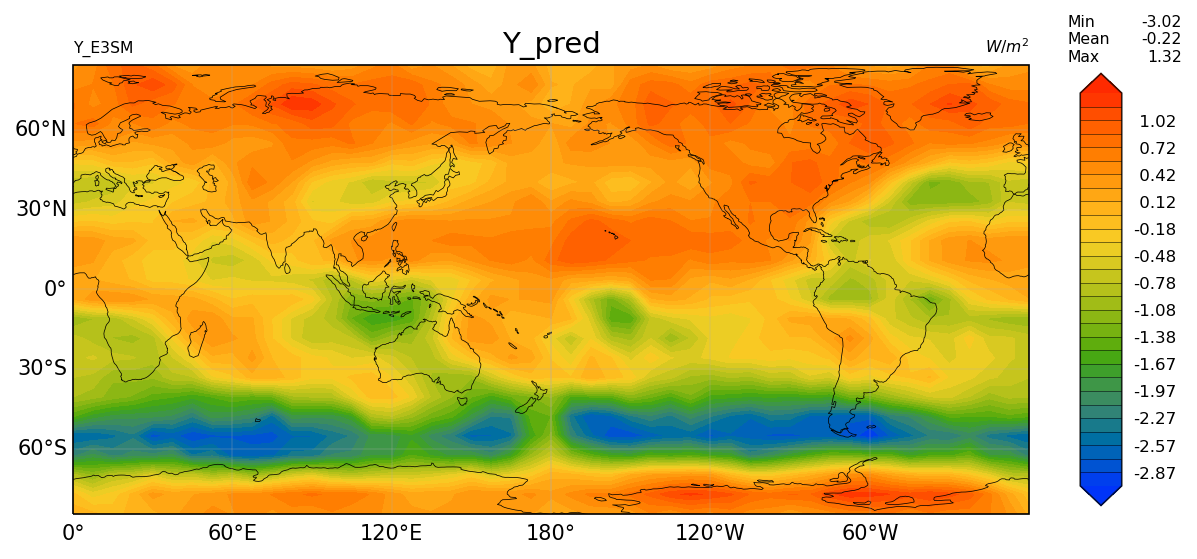

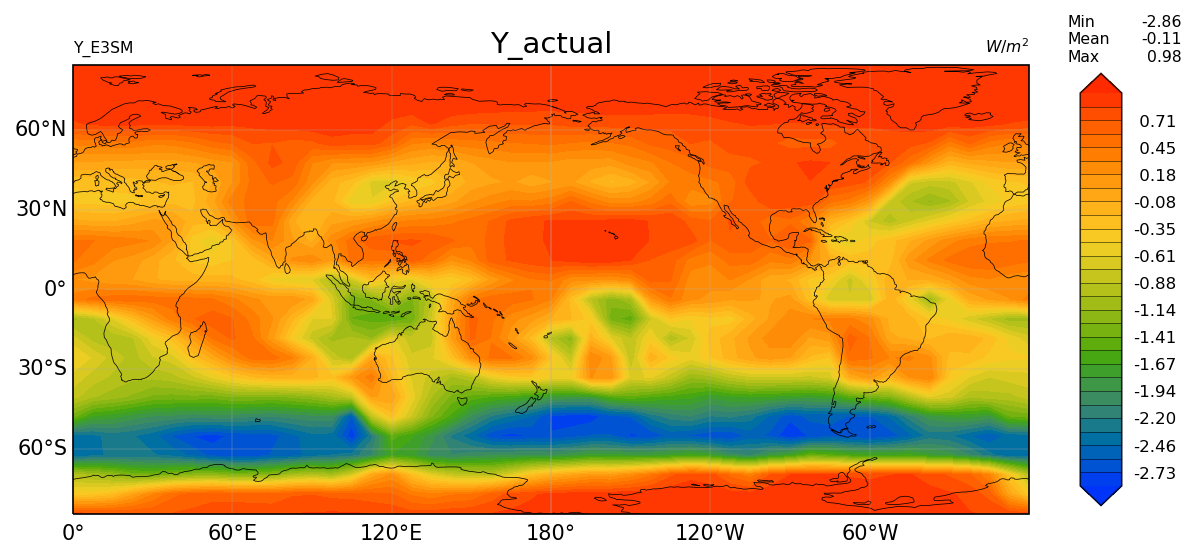

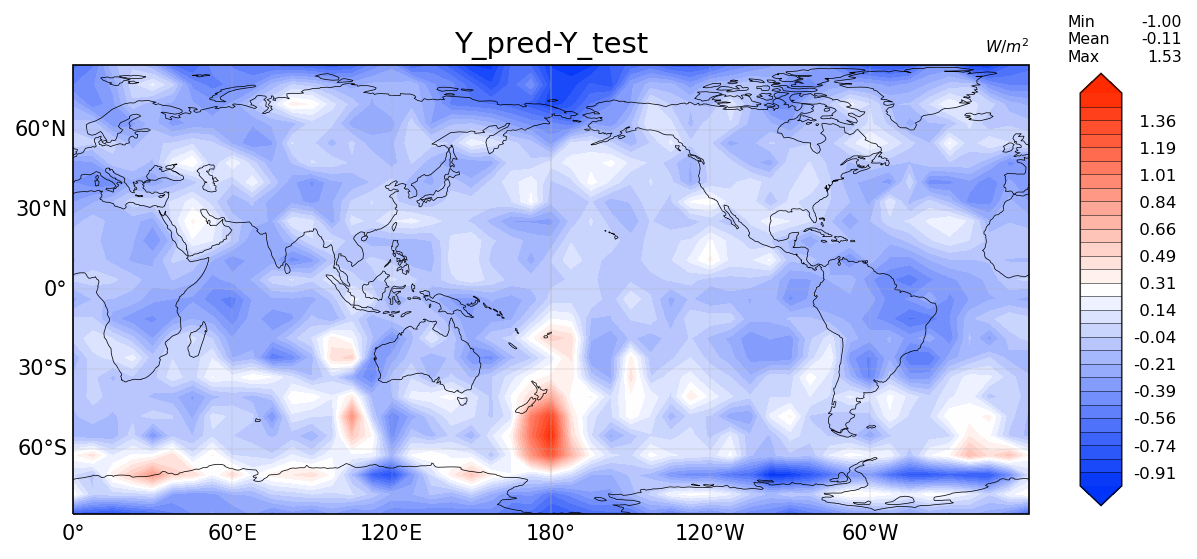

In [272]:
plot(Y_pred,Y_test,-1)

In [273]:
mse=np.mean(np.square(Y_pred.squeeze()-Y_test))

In [274]:
mse

0.07037065

## Map from Y to X

In [153]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3), strides=(1, 1),activation='leaky_relu',input_shape=(24,48,1),padding='same'))
model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
# model2.add(tf.keras.layers.BatchNormalization())
# model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
# model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
# model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
# model2.add(tf.keras.layers.BatchNormalization())
# model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Reshape((9,)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(5, activation='tanh'))


In [154]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 24, 48, 1)         10        
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 24, 3)         78        
                                                                 
 batch_normalization_19 (Bat  (None, 12, 24, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 24, 3)         228       
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 12, 3)          228       
                                                                 
 batch_normalization_20 (Bat  (None, 6, 12, 3)         12        
 chNormalization)                                     

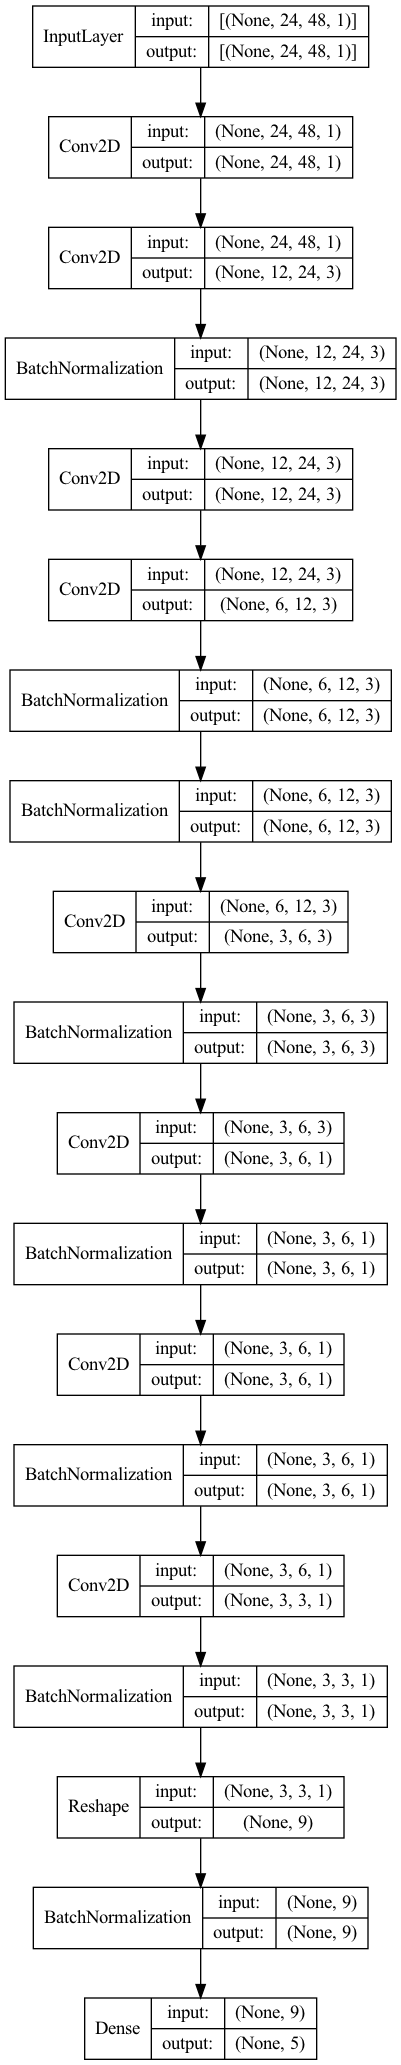

In [155]:
plot_model(model2, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [173]:
def custom_loss2(y_pred,y_actual):
    return kb.square(y_pred-y_actual)

In [174]:
model2.compile(optimizer=tf.optimizers.Adam(),loss=custom_loss2,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])

In [175]:
X_train.shape

(205, 5)

In [176]:
Y_train.shape

(205, 24, 48)

In [177]:
history=model2.fit(Y_train,X_train,epochs=1000)

Epoch 1/1000
7/7 [==============================] - 1s 41ms/step - loss: 0.6279 - root_mean_squared_error: 0.7924
Epoch 2/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.4331 - root_mean_squared_error: 0.6581
Epoch 3/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.3438 - root_mean_squared_error: 0.5863
Epoch 4/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.3139 - root_mean_squared_error: 0.5603
Epoch 5/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.2955 - root_mean_squared_error: 0.5436
Epoch 6/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.2603 - root_mean_squared_error: 0.5102
Epoch 7/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.2419 - root_mean_squared_error: 0.4918
Epoch 8/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.2248 - root_mean_squared_error: 0.4742
Epoch 9/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.2144 - root_m

7/7 [==============================] - 0s 16ms/step - loss: 0.1210 - root_mean_squared_error: 0.3479
Epoch 73/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1197 - root_mean_squared_error: 0.3459
Epoch 74/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1183 - root_mean_squared_error: 0.3440
Epoch 75/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1089 - root_mean_squared_error: 0.3301
Epoch 76/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1082 - root_mean_squared_error: 0.3289
Epoch 77/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1078 - root_mean_squared_error: 0.3284
Epoch 78/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1128 - root_mean_squared_error: 0.3359
Epoch 79/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.1079 - root_mean_squared_error: 0.3285
Epoch 80/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1095 - root_mean_s

Epoch 143/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0538 - root_mean_squared_error: 0.2319
Epoch 144/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0536 - root_mean_squared_error: 0.2315
Epoch 145/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0570 - root_mean_squared_error: 0.2388
Epoch 146/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0530 - root_mean_squared_error: 0.2302
Epoch 147/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0506 - root_mean_squared_error: 0.2250
Epoch 148/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0527 - root_mean_squared_error: 0.2295
Epoch 149/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415
Epoch 150/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0494 - root_mean_squared_error: 0.2222
Epoch 151/1000
7/7 [==============================] - 0s 14ms/step - los

7/7 [==============================] - 0s 14ms/step - loss: 0.0422 - root_mean_squared_error: 0.2055
Epoch 214/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0399 - root_mean_squared_error: 0.1999
Epoch 215/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002
Epoch 216/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075
Epoch 217/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023
Epoch 218/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0377 - root_mean_squared_error: 0.1943
Epoch 219/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0431 - root_mean_squared_error: 0.2077
Epoch 220/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927
Epoch 221/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0467 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990
Epoch 284/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943
Epoch 285/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968
Epoch 286/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0394 - root_mean_squared_error: 0.1986
Epoch 287/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951
Epoch 288/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908
Epoch 289/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0329 - root_mean_squared_error: 0.1815
Epoch 290/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0356 - root_mean_squared_error: 0.1886
Epoch 291/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0348 - roo

7/7 [==============================] - 0s 16ms/step - loss: 0.0273 - root_mean_squared_error: 0.1651
Epoch 354/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0317 - root_mean_squared_error: 0.1780
Epoch 355/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934
Epoch 356/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747
Epoch 357/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0322 - root_mean_squared_error: 0.1793
Epoch 358/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0292 - root_mean_squared_error: 0.1709
Epoch 359/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0284 - root_mean_squared_error: 0.1685
Epoch 360/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879
Epoch 361/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0290 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737
Epoch 424/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851
Epoch 425/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918
Epoch 426/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714
Epoch 427/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0359 - root_mean_squared_error: 0.1896
Epoch 428/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884
Epoch 429/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747
Epoch 430/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0307 - root_mean_squared_error: 0.1752
Epoch 431/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0296 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0277 - root_mean_squared_error: 0.1663
Epoch 494/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0291 - root_mean_squared_error: 0.1706
Epoch 495/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783
Epoch 496/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0329 - root_mean_squared_error: 0.1813
Epoch 497/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744
Epoch 498/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0303 - root_mean_squared_error: 0.1742
Epoch 499/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703
Epoch 500/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636
Epoch 501/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0283 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861
Epoch 564/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0335 - root_mean_squared_error: 0.1832
Epoch 565/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0281 - root_mean_squared_error: 0.1676
Epoch 566/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702
Epoch 567/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0281 - root_mean_squared_error: 0.1677
Epoch 568/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683
Epoch 569/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763
Epoch 570/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0272 - root_mean_squared_error: 0.1648
Epoch 571/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0251 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618
Epoch 634/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426
Epoch 635/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749
Epoch 636/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624
Epoch 637/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724
Epoch 638/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910
Epoch 639/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693
Epoch 640/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0296 - root_mean_squared_error: 0.1720
Epoch 641/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0231 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0249 - root_mean_squared_error: 0.1578
Epoch 704/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0275 - root_mean_squared_error: 0.1657
Epoch 705/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 706/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672
Epoch 707/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601
Epoch 708/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0289 - root_mean_squared_error: 0.1701
Epoch 709/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0256 - root_mean_squared_error: 0.1599
Epoch 710/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508
Epoch 711/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0208 - roo

7/7 [==============================] - 0s 14ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529
Epoch 774/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563
Epoch 775/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0245 - root_mean_squared_error: 0.1565
Epoch 776/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0216 - root_mean_squared_error: 0.1468
Epoch 777/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532
Epoch 778/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 779/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619
Epoch 780/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569
Epoch 781/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0239 - roo

7/7 [==============================] - 0s 14ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465
Epoch 844/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0242 - root_mean_squared_error: 0.1554
Epoch 845/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381
Epoch 846/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474
Epoch 847/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0213 - root_mean_squared_error: 0.1458
Epoch 848/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553
Epoch 849/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531
Epoch 850/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464
Epoch 851/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0233 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551
Epoch 914/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0218 - root_mean_squared_error: 0.1477
Epoch 915/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0246 - root_mean_squared_error: 0.1568
Epoch 916/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637
Epoch 917/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432
Epoch 918/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510
Epoch 919/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0258 - root_mean_squared_error: 0.1608
Epoch 920/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0190 - root_mean_squared_error: 0.1380
Epoch 921/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0205 - roo

7/7 [==============================] - 0s 15ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523
Epoch 984/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346
Epoch 985/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503
Epoch 986/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502
Epoch 987/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551
Epoch 988/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484
Epoch 989/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532
Epoch 990/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0233 - root_mean_squared_error: 0.1528
Epoch 991/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0254 - roo

In [178]:
x_pred=model2.predict(Y_test)

In [179]:
Y_test.shape

(50, 24, 48)

In [180]:
x_pred.min(),x_pred.max()

(-0.9608059, 0.9506177)

In [181]:
model2.evaluate(Y_train,X_train)

7/7 [==============================] - 0s 19ms/step - loss: 0.0399 - root_mean_squared_error: 0.1997


[0.039894893765449524, 0.1997370719909668]

In [182]:
model2.evaluate(Y_test,X_test)

2/2 [==============================] - 0s 68ms/step - loss: 0.1330 - root_mean_squared_error: 0.3647


[0.13298816978931427, 0.36467546224594116]

In [183]:
Y_obs.shape

(24, 48)

In [184]:
Y_test.shape

(50, 24, 48)

In [185]:
Y_obs_re=Y_obs.reshape(1,24,48)

In [186]:
Y_obs_re.shape

(1, 24, 48)

In [187]:
x_obs_a=model2.predict(Y_obs_re)

In [188]:
x_obs_a

array([[-0.7130515 ,  0.9975353 , -0.92481583, -0.4341553 ,  0.32638425]],
      dtype=float32)

In [189]:
Y_obs_pred=model.predict(x_obs_a)

In [190]:
test=model.predict(X_test)

[[ 0.9678669   0.92852414  0.9554509  ...  0.76759005  0.85091543
   0.7516626 ]
 [ 0.81621933  0.67848897  0.8754214  ...  0.3971093   0.68538487
   0.8156987 ]
 [-0.03713274 -0.0186314  -0.05771133 ... -0.9709296  -0.68336797
  -0.2307528 ]
 ...
 [ 0.8313985   0.93267965  1.027376   ...  0.8682713   0.95426476
   0.91605747]
 [ 0.77277327  0.8540429   1.033578   ...  0.9128076   0.9337003
   0.7988254 ]
 [ 0.82137567  1.0125806   0.96755385 ...  0.8698393   0.87775064
   0.8559692 ]]


/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

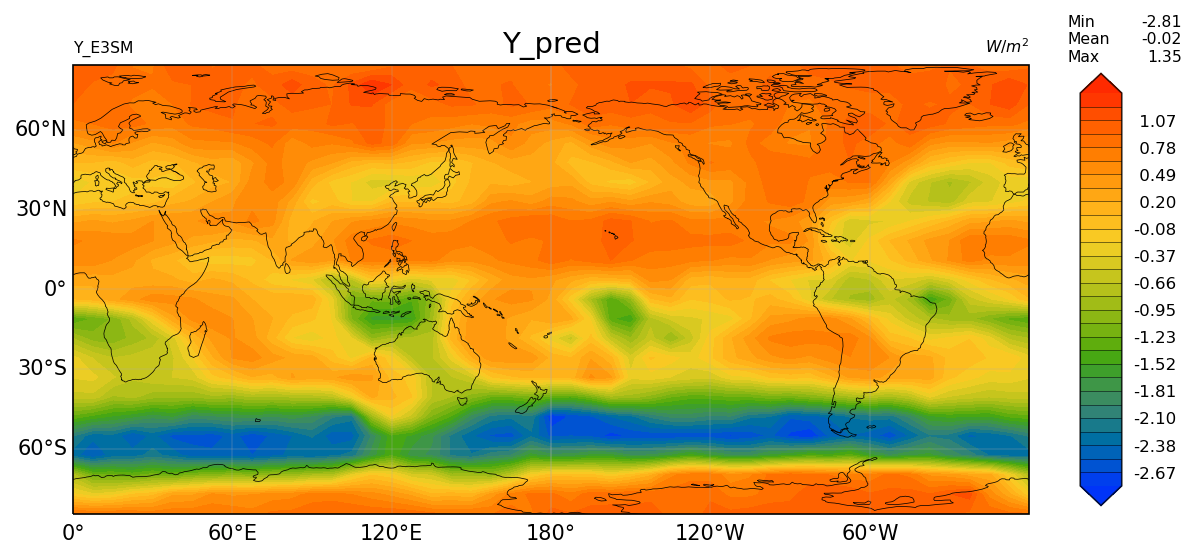

In [191]:
lat = dataset['lat'].values
lon = dataset['lon'].values
Y_plot=np.reshape(Y_obs_pred,(24,48))
print(Y_plot)
y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_pred",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_pred_xr)

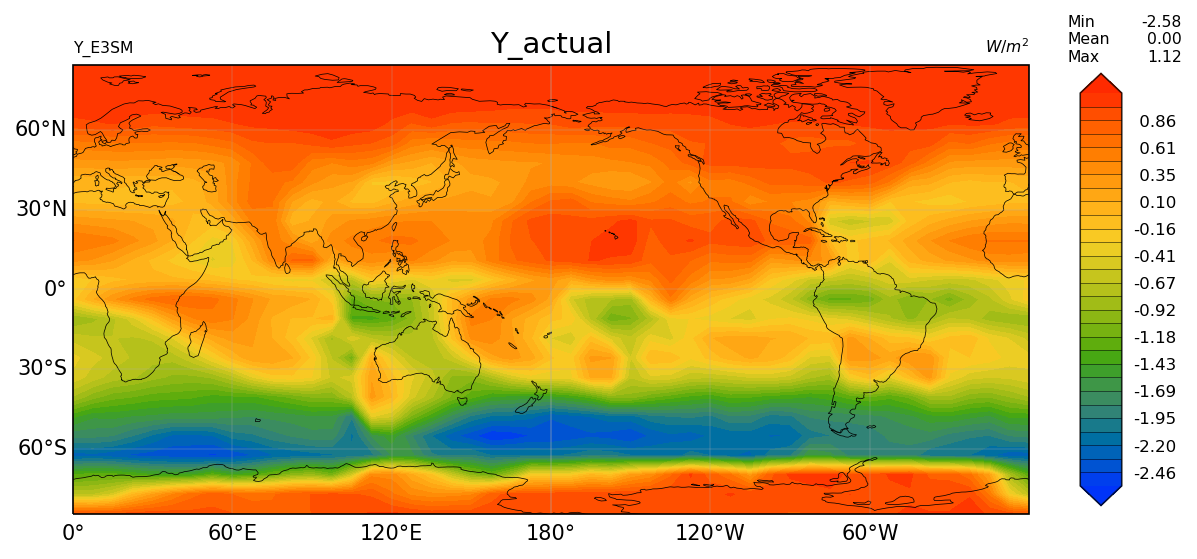

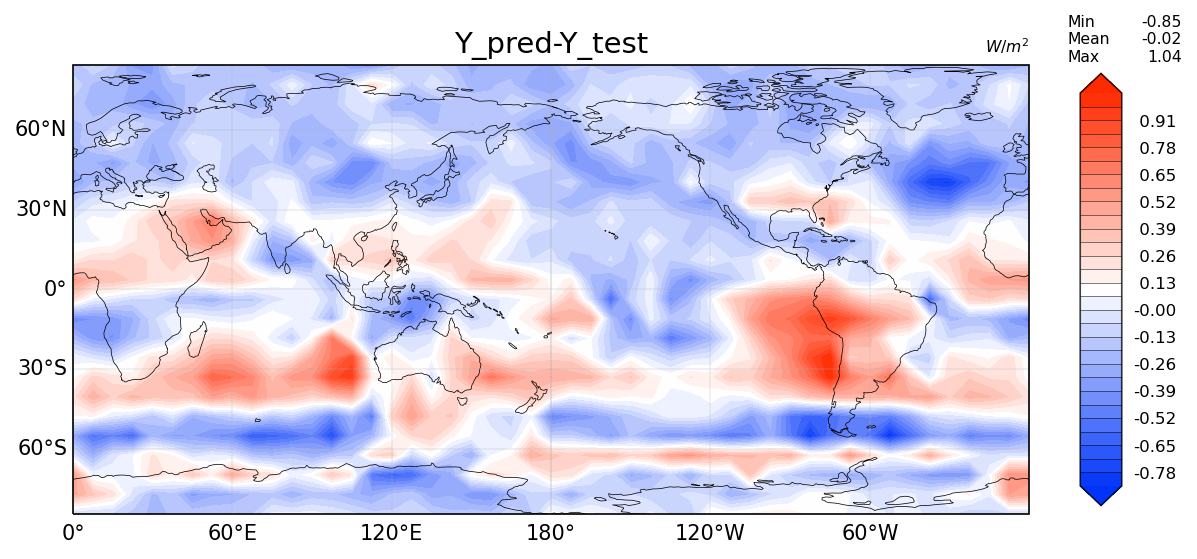

In [192]:
Y_plot=np.reshape(Y_obs,(24,48))
y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_actual",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_obs_xr)
sample_plot = cviz.contour.plot_lat_lon(
cmap_name="e3sm_default_diff",
title="Y_pred-Y_test",
rhs_title=r"$W/m^2$",
lhs_title="",
)
sample_plot.show((y_pred_xr-y_obs_xr))